In [68]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [69]:
import pandas as pd
import numpy as np

In [70]:
from pyspark.sql import SparkSession

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

# 1.Read the data in and check the presence of null value

In [71]:
# function used to check the presence of null values.
def check_null_value(dataframe):
    for columns in dataframe.columns:
        print('Number of null value in', columns, ':', dataframe.where(F.col(columns).isNull()).count())
    return

In [72]:
consumer_id = spark.read.parquet('../data/tables/consumer_user_details.parquet')
check_null_value(consumer_id)

Number of null value in user_id : 0
Number of null value in consumer_id : 0


In [73]:
# Use pandas read consumer csv
raw_consumer_df = spark.read.option("header",True).csv('../data/tables/tbl_consumer.csv')
check_null_value(raw_consumer_df)

Number of null value in name : 0
Number of null value in address : 0
Number of null value in state : 0
Number of null value in postcode : 0
Number of null value in gender : 0
Number of null value in consumer_id : 0


In [74]:
merchant_df = spark.read.parquet('../data/tables/tbl_merchants.parquet').withColumnRenamed('name','merchant_name')
check_null_value(merchant_df)

Number of null value in merchant_name : 0
Number of null value in tags : 0
Number of null value in merchant_abn : 0


In [75]:
path_list = []
period = pd.date_range('2021-2-28','2021-03-31', freq='D').strftime("%Y-%m-%d").tolist()
path_prefix = '../data/tables/transactions_20210228_20210827_snapshot/order_datetime='
for date in period:
    path_list.append(path_prefix + date)
    
raw_transactions_df = spark.read.parquet(*path_list)

check_null_value(raw_transactions_df)

Number of null value in user_id : 0
Number of null value in merchant_abn : 0
Number of null value in dollar_value : 0
Number of null value in order_id : 0


#### No null value is found in the raw datasets.

# 2. Data aggregation

First, we aggregate the given consumer, merchant and transactions data, drop the irrelevant features for the ranking system such as consumers' id and name, transactions' order id and merchants' abn.

In [76]:
consumer_df =  consumer_id.join(raw_consumer_df, consumer_id.consumer_id == raw_consumer_df.consumer_id, 'inner')\
                            .withColumnRenamed('name','consumer_name')\
                            .withColumnRenamed('address','consumer_address')

In [77]:
transactions_df = raw_transactions_df.join(merchant_df, raw_transactions_df.merchant_abn == merchant_df.merchant_abn, 'inner')\
                           .join(consumer_df, raw_transactions_df.user_id == consumer_df.user_id, 'inner')\
                           .drop('merchant_abn', 'order_id', 'user_id', 'consumer_id', 'consumer_name')

In [78]:
raw_transactions_df.count(), transactions_df.count()

(563440, 540364)

Since some merchant abns from the transaction data do not match with any merchant from the merchant, we should remove them by inner join with the merchant dataset. About  5% of data are eliminated.

In [79]:
transactions_df.limit(10)

dollar_value,merchant_name,tags,consumer_address,state,postcode,gender
188.28973315308076,Vulputate Dui Nec...,[[computer progra...,122 Brandon Cliff,QLD,4606,Female
104.28588019514527,Semper Incorporated,([digital goods: ...,122 Brandon Cliff,QLD,4606,Female
31.24707699002731,Suspendisse Dui C...,"((opticians, opti...",122 Brandon Cliff,QLD,4606,Female
24.235220789680053,Eu Dui Cum Ltd,[[tent and awning...,122 Brandon Cliff,QLD,4606,Female
62.10343310638136,Lorem Ipsum Sodal...,([florists suppli...,122 Brandon Cliff,QLD,4606,Female
179.95765381097175,Phasellus Dapibus...,[(motor vehicle s...,122 Brandon Cliff,QLD,4606,Female
89.93535555889761,Hendrerit Corpora...,"((gift, card, nov...",122 Brandon Cliff,QLD,4606,Female
427.9830846366457,At PC,"[[computers, comp...",122 Brandon Cliff,QLD,4606,Female
107.59365756886233,Nam Interdum Ltd,[[florists suppli...,122 Brandon Cliff,QLD,4606,Female
25.296741327912205,Leo In Consulting,"[[watch, clock, a...",122 Brandon Cliff,QLD,4606,Female


We compute the total income and number of transactions for each merchant for the preliminary analysis.

In [80]:
merchant_income = transactions_df.groupBy('merchant_name', 'tags')\
                  .agg(
                       F.round(F.sum('dollar_value'),2).alias('total_income'),
                       F.count('merchant_name').alias('total_transactions'))\
                  .orderBy('total_income', ascending = False)\
                  .withColumn('mean_transaction_amount',  F.round(F.col('total_income')/F.col('total_transactions')))

In [81]:
merchant_income.toPandas()

,merchant_name,tags,total_income,total_transactions,mean_transaction_amount
0,Amet Risus Inc.,"([furniture, home furnishings and equipment sh...",461558.32,213,2167.0
1,Lacus Aliquam Corporation,"[(antique shops - sales, repairs, and restora...",424664.29,62,6849.0
2,Nec Incorporated,"[[telecom], [a], [take rate: 5.55]]",398455.26,218,1828.0
3,Commodo Ipsum Industries,"([jewelry, watch, Clock, and silverware shops]...",396344.19,36,11010.0
4,Ornare Limited,"([motor vehicle supplies and new parts], [a], ...",388384.73,1234,315.0
...,...,...,...,...,...
3679,Dictum Incorporated,"([arTist supply and craft shops], [a], [take r...",66.71,1,67.0
3680,Maecenas Mi Felis Limited,"([health and beauty spas], [b], [take rate: 5....",56.66,1,57.0
3681,Adipiscing Elit Company,"([artist supply and craft shops], [c], [take r...",50.15,1,50.0
3682,Odio Consulting,"[[computeR programming , data processing, and ...",42.19,2,21.0


In [82]:
merchant_income.orderBy('total_transactions', ascending = False).toPandas()

,merchant_name,tags,total_income,total_transactions,mean_transaction_amount
0,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...",342276.83,11366,30.0
1,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...",383480.78,10981,35.0
2,Pede Nonummy Corp.,"((tent and awning shops), (c), (take rate: 2.86))",298106.19,10387,29.0
3,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",283962.38,9827,29.0
4,Suspendisse Dui Corporation,"((opticians, optical goods, and eyeglasses), (...",279790.38,9330,30.0
...,...,...,...,...,...
3679,Fermentum Metus Ltd,"([jewelry, watch, clock, and silverware shops]...",5593.31,1,5593.0
3680,Ac Arcu Inc.,"([artist supply and craft shops], [c], [take r...",541.42,1,541.0
3681,Non Foundation,"((equipment, tool, furniture, and appliance re...",992.78,1,993.0
3682,Ullamcorper Corp.,"[(books, periodicals, and newspapers), (b), (t...",104.82,1,105.0


In [83]:
merchant_income.orderBy('mean_transaction_amount', ascending = False).toPandas()

,merchant_name,tags,total_income,total_transactions,mean_transaction_amount
0,Lacinia Orci Incorporated,"([antique shops - sales, repairs, and restorat...",65774.72,2,32887.0
1,Accumsan Corporation,"[(jewelRy, watch, clock, and silverware shops)...",103485.33,4,25871.0
2,Diam Nunc Associates,"((jewelry, watch, clock, and silverware shops)...",99950.11,4,24988.0
3,Ligula Elit Pretium Foundation,"[[antique shops - sales, repairs, and restorat...",158303.12,7,22615.0
4,Ut Corporation,"((antique shops - sales, repairs, and resTorat...",43610.64,2,21805.0
...,...,...,...,...,...
3679,Urna Nullam Lobortis Institute,"((tent and awning shops), (b), (take rate: 3.48))",719.32,55,13.0
3680,Malesuada Fringilla Est Institute,"[(tent and Awning shops), (a), (take rate: 5....",732.90,59,12.0
3681,Eros Limited,"[[digital goods: books, movies, music], [c], [...",24845.59,2147,12.0
3682,Pretium Neque Inc.,"([tent and awning shops], [a], [take rate: 5.80])",1616.39,132,12.0


In [84]:
merchant_income.count(), merchant_df.count()

(3684, 4026)

About 350 merchants does not have any transactions in this month, a longer period of data should be considered. 

# 3. Preliminarily check distribution of data

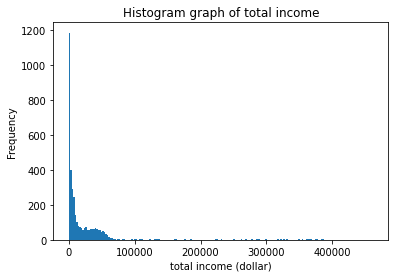

In [85]:
bins, counts = merchant_income.select('total_income').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('total income (dollar)')
plt.title('Histogram graph of total income')
plt.savefig('../plots/Histogram graph of total income')
plt.show()

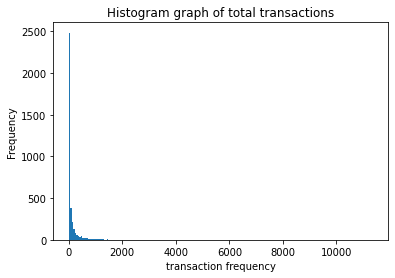

In [86]:
bins, counts = merchant_income.select('total_transactions').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('transaction frequency')
plt.title('Histogram graph of total transactions')
plt.savefig('../plots/Histogram graph of total transactions')
plt.show()

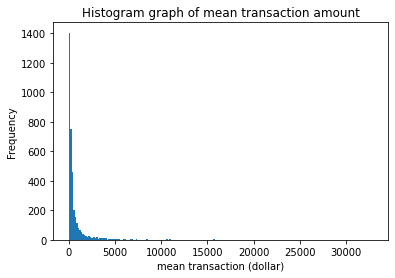

In [87]:
bins, counts = merchant_income.select('mean_transaction_amount').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('mean transaction (dollar)')
plt.title('Histogram graph of mean transaction amount')
plt.savefig('../plots/Histogram graph of mean transaction amount')
plt.show()

There are some extremely large values, outliers elimination and data transformation may be needed.